In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import itertools

In [4]:
path_mac = "/Users/pritam/Desktop/DIP/Assignment 2/DIP2025/images/images"
path_window = 'DIP2025\\Assignment2\\images'
image_folder_path = Path(path_mac)
all_images = []
for image_path in image_folder_path.glob('*'):
    if image_path.is_file():
        try:
            with Image.open(image_path) as img:
                all_images.append(img.copy())
            print(f"Loaded image: {image_path.name}")
        except IOError:
            print(f"Could not load image: {image_path.name}")
print(f"\nSuccessfully loaded {len(all_images)} images.")


Loaded image: flowers.png
Loaded image: study.png
Loaded image: moon_noisy.png
Loaded image: sharp.png

Successfully loaded 4 images.


In [ ]:
flowers, study, moon_noisy, study = all_images

In [36]:
class FilteringAndBinarization:
    def __init__(self, m):
        self.m = m

    def box_filter(self, m):
        box = np.ones((m, m), dtype=float)
        return box / (m * m)

    def convolve(self, image, kernel):
        if isinstance(image, Image.Image):
            image = image.convert('L')
            image = np.array(image)
        elif image.ndim == 3:  # RGB as np array
            image = np.mean(image, axis=2).astype(np.uint8) # Simply taking the mean of values of channels

        kernel_size = kernel.shape[0]
        pad = kernel_size // 2
        rows, cols = image.shape

        padded = np.pad(image, pad, mode='reflect')
        conv_image = np.zeros_like(image, dtype=float)

        for i in range(rows):
            for j in range(cols):
                patch = padded[i:i+kernel_size, j:j+kernel_size]
                conv_image[i, j] = np.sum(patch * kernel)

        return conv_image.astype(np.uint8)

    def histogram_compute(self, img):
        if isinstance(img, Image.Image):
            img = img.convert('L')
            img = np.array(img)
        elif img.ndim == 3:  # RGB as np array
            img = np.mean(img, axis=2).astype(np.uint8) 

        gray_img = img.ravel()
        mn = len(gray_img)
        hist, bins = np.histogram(gray_img, bins=256, range=(0, 256))
        return hist / mn

    def otsu_binarization(self, norm_histogram, threshold):
        class0_prob = np.sum(norm_histogram[:threshold+1])
        class1_prob = 1 - class0_prob

        if class0_prob > 0:
            class0_mean = np.sum(np.arange(0, threshold+1) * norm_histogram[:threshold+1]) / class0_prob
        else:
            class0_mean = 0

        if class1_prob > 0:
            class1_mean = np.sum(np.arange(threshold+1, 256) * norm_histogram[threshold+1:]) / class1_prob
        else:
            class1_mean = 0

        return class0_prob * class1_prob * (class1_mean - class0_mean) ** 2

    def otsu_threshold(self, img):
        # Compute normalized histogram
        norm_hist = self.histogram_compute(img)
        # Maximize between-class variance
        variances = [self.otsu_binarization(norm_hist, t) for t in range(256)]
        return np.argmax(variances)


In [103]:
kernel_sizes = [5,29,129]
bw_variances = []
OtsuThresholds = []
bin_images = []
hists = []
convolved_images = [moon_noisy]

In [104]:
for m in [5, 29, 129]:
    q1 = FilteringAndBinarization(m)
    kernel = q1.box_filter(m)
    conv_img = q1.convolve(moon_noisy, kernel)
    convolved_images.append(conv_img.copy())
    # Store raw intensities (for plotting histograms later)
    hists.append(conv_img.ravel())
    
    # Normalized histogram
    norm_hist = q1.histogram_compute(conv_img)
    
    # Otsu threshold
    threshold = q1.otsu_threshold(conv_img)
    OtsuThresholds.append(threshold)
    
    # Between-class variance
    bw_variances.append(q1.otsu_binarization(norm_hist, threshold=threshold))
    
    # Binarization
    binary_img = conv_img.copy()
    binary_img[binary_img <= threshold] = 0
    binary_img[binary_img > threshold] = 1
    bin_images.append(binary_img)


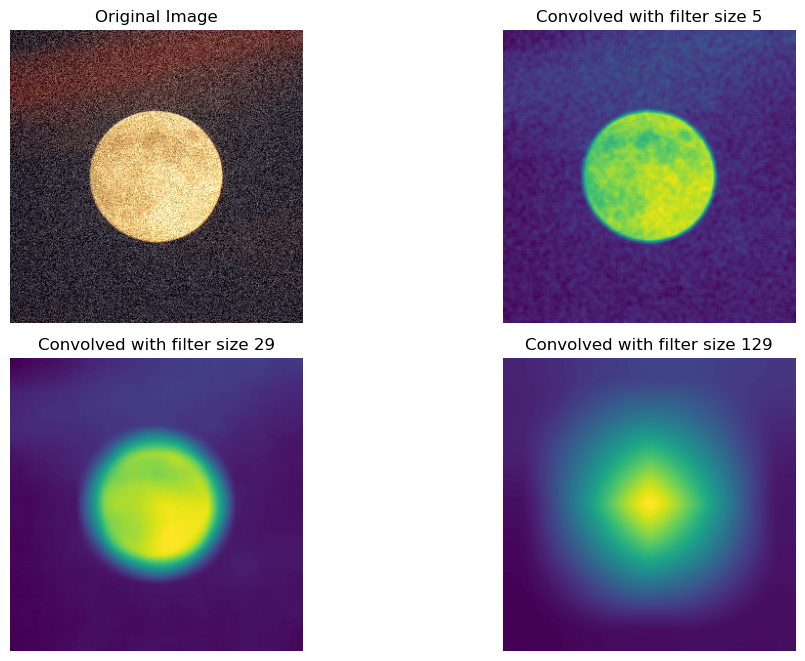

In [105]:
plt.figure(figsize=(10, 10))
titles = ["Original Image"] + [f"Convolved with filter size {m}" for m in kernel_sizes]

for i, img in enumerate(convolved_images):
    plt.subplot(3, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(titles[i])

plt.tight_layout()
plt.show()


In [106]:
for i in range(len(bw_variances)):
    print(f"Between class variance for kernel size {kernel_sizes[i]} is {bw_variances[i]:0.2f}")

Between class variance for kernel size 5 is 2960.26
Between class variance for kernel size 29 is 2397.43
Between class variance for kernel size 129 is 761.02


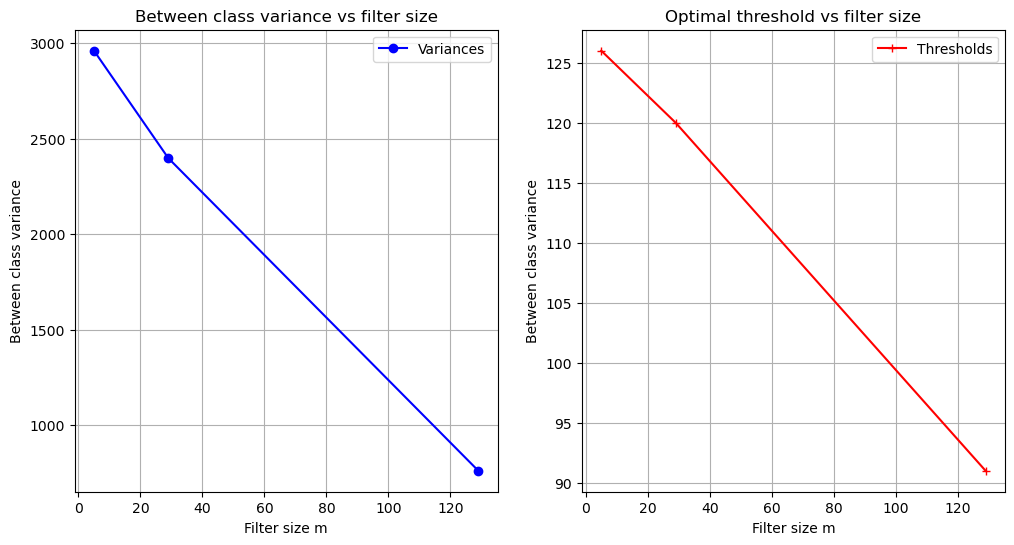

In [112]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(kernel_sizes, bw_variances, marker = 'o', color= 'b', label='Variances')
plt.legend()
plt.title("Between class variance vs filter size")
plt.xlabel("Filter size m")
plt.ylabel("Between class variance")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(kernel_sizes, OtsuThresholds, marker = '+', color= 'r', label = 'Thresholds')
plt.legend()
plt.title("Optimal threshold vs filter size")
plt.xlabel("Filter size m")
plt.ylabel("Between class variance")
plt.grid(True)
plt.show()

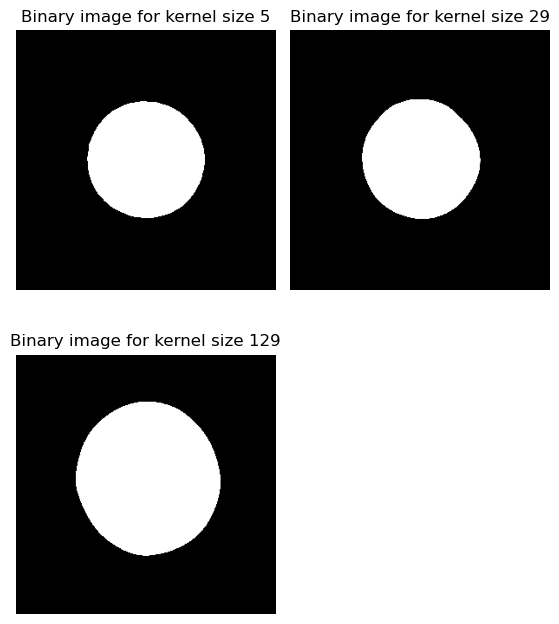

In [113]:
plt.figure(figsize=(6,7))
for i, bin_img in enumerate(bin_images):
    plt.subplot(2,2,i+1)
    plt.imshow(bin_img, cmap='gray')
    plt.tight_layout()
    plt.title(f"Binary image for kernel size {kernel_sizes[i]}")
    plt.axis('off')
plt.show()

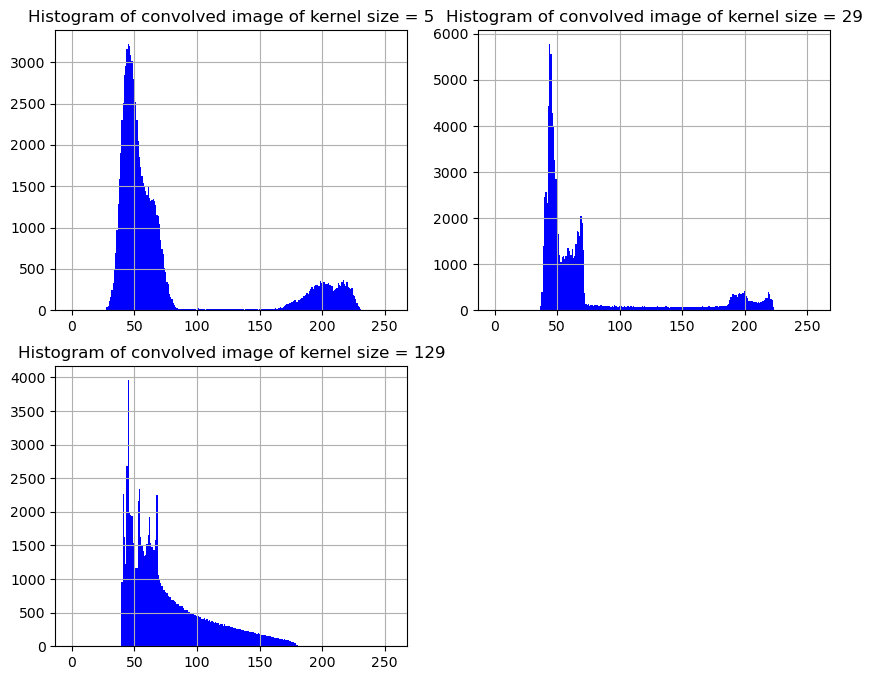

In [114]:
plt.figure(figsize=(10,8))
for i,hist_array in enumerate(hists):
    plt.subplot(2,2,i+1)
    hist, bins=np.histogram(hist_array, bins=256, range=(0,256))
    plt.bar(bins[:-1], hist, width=1, color='blue')
    plt.grid(True)
    plt.title(f"Histogram of convolved image of kernel size = {kernel_sizes[i]}")
plt.show()

###  Upsample grayscale image by a given scale using bilinear interpolation.

In [ ]:
def bilinear_resize(img, scale=2): 
    H, W = img.shape # Get the dimension of the image
    new_H, new_W = int(H * scale), int(W * scale) #Get the new dimension after scaling
    upsampled = np.zeros((new_H, new_W), dtype=img.dtype) #Creating an emtpy array or container to replace with the values after upsampling

    for i, j in itertools.product(range(new_H), range(new_W)): #Loop over every pixel in the upsampled image
        # Map output pixel (i, j) back to floating-point coordinates in the input image
        x = i / scale #eg upsampled (1,1)-> (0.5, 0.5) in original image
        y = j / scale

        x0, y0 = int(np.floor(x)), int(np.floor(y)) # Find the top-left corner pixel (x0, y0) in the original image
        x1, y1 = min(x0 + 1, H - 1), min(y0 + 1, W - 1) # Find the neighboring pixel to the right (y1) and below (x1) and clamp them to image boundaries to avoid going out of range

        dx, dy = x - x0, y - y0 # Compute distances from the top-left pixel (fractional part)

        # Get the intensities of the four corners(Neighbours) 
        Ia = img[x0, y0] #Intensity of top left in the original image
        Ib = img[x0, y1] #Top right
        Ic = img[x1, y0] #Bottom left
        Id = img[x1, y1] # Bottom right
        #Compute bilinear interpolation. Weighted sum of the four neighbours based on distances (dx,dy)
        upsampled[i, j] = (Ia * (1 - dx) * (1 - dy) +  #Weight for top left intensity
                            Ib * (1 - dx) * dy + #Weight for top right intensity
                            Ic * dx * (1 - dy) + #Weight for bottom left intensity
                            Id * dx * dy) #Weight for bottom right intensity
    return upsampled


In [45]:
def rotate_image(img, theta):
    H, W = img.shape # Get the dimension of the image
    rotated = np.zeros_like(img) #Create a container of 0s. 

    cx, cy = H // 2, W // 2 #Find the center of the original image
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    for i, j in itertools.product(range(H), range(W)):
        a1 = (i - cx) * cos_t + (j - cy) * sin_t + cx # Gives the x-co-ordinate of the rotated image by theta in counter-clockwise direction
        a2 = -(i - cx) * sin_t + (j - cy) * cos_t + cy # Gives the y-co-ordinate of the rotated image by theta in counter-clockwise direction

        if 0 <= a1 < H - 1 and 0 <= a2 < W - 1: # To make sure cordinates do not go out of the image
            x0, y0 = int(np.floor(a1)), int(np.floor(a2)) #Get the top-left cordinate
            x1, y1 = x0 + 1, y0 + 1 #Get the bottom right cordinates

            dx, dy = a1 - x0, a2- y0 # Get the distances of x and y-cordinates b/w cordinate we got after rotation and its top-left corner. 

            Ia = img[x0, y0]    #Get the intensity of the top-left in the original image
            Ib = img[x0, y1]    #Get the intensity of the top-right in the original image
            Ic = img[x1, y0]    #Get the intensity of the bottom-left in the original image
            Id = img[x1, y1]    #Get the intensity of the bottom-right in the original image
        #Now compute bilinear interpolation. Weighted sum of the four neighbours based on distances (dx,dy)
            rotated[i, j] = (Ia * (1 - dx) * (1 - dy) +  #Weight for top left intensity
                            Ib * (1 - dx) * dy + #Weight for top right intensity
                            Ic * dx * (1 - dy) + #Weight for bottom left intensity
                            Id * dx * dy) #Weight for bottom right intensity
    return rotated.astype(img.dtype)

In [60]:
img = np.array(flowers) 
upsampled_a = bilinear_resize(img, scale=2)
rotated_a = rotate_image(upsampled_a, np.deg2rad(45))

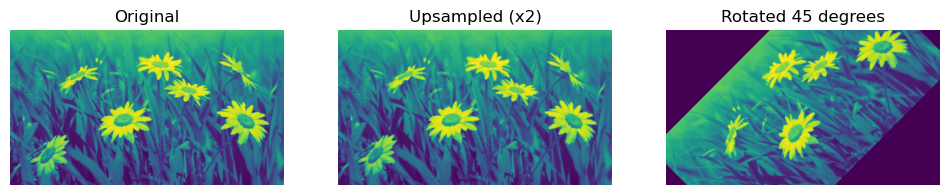

In [61]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(upsampled_a); plt.title("Upsampled (x2)"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(rotated_a); plt.title("Rotated 45 degrees"); plt.axis("off")
plt.show()

In [62]:
print(f"Shape of the original image is {img.shape}")
print(f"Shape of the upsampled image is {upsampled_a.shape}")
print(f"Shape of the rotated image is {rotated_a.shape}")


Shape of the original image is (227, 400)
Shape of the upsampled image is (454, 800)
Shape of the rotated image is (454, 800)


### b. Rotate and upsample the image

In [63]:
rotated_b = rotate_image(img,theta=np.pi/4)
upsampled_b = bilinear_resize(rotated_b,2)

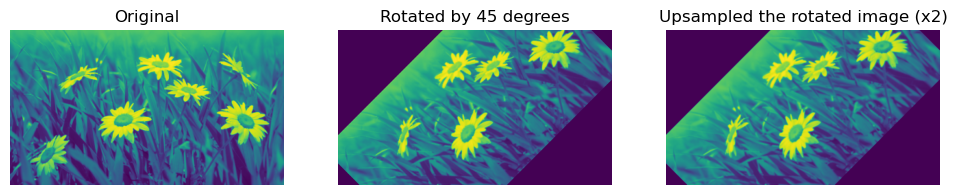

In [64]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(rotated_b); plt.title("Rotated by 45 degrees"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(upsampled_b); plt.title("Upsampled the rotated image (x2)"); plt.axis("off")
plt.show()

### Compute the difference b/w the images we finally got in part a and part b

In [76]:
diff = rotated_a-upsampled_b
print(f"The minimum of the difference is {np.min(diff):.2f} and the maximum of the diff is {np.max(diff):.2f}")

The minimum of the difference is 0.00 and the maximum of the diff is 255.00


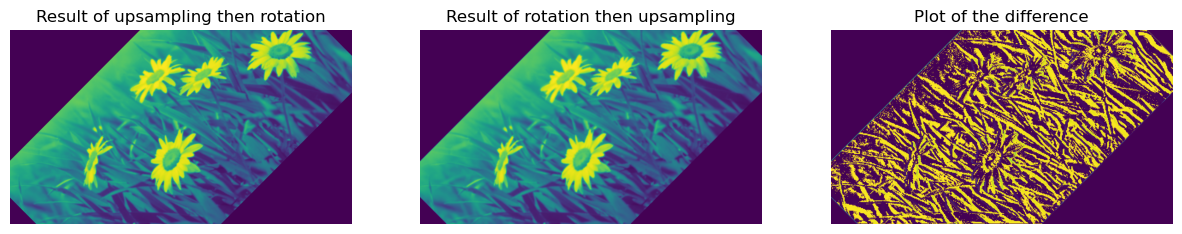

In [74]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(rotated_a)
plt.title("Result of upsampling then rotation")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(upsampled_b)
plt.title("Result of rotation then upsampling")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(diff)
plt.axis('off')
plt.title("Plot of the difference")
plt.show()

## 3. Image Sharpening

In [ ]:
study_array = np.array(study)
study_array.shape

(373, 560)

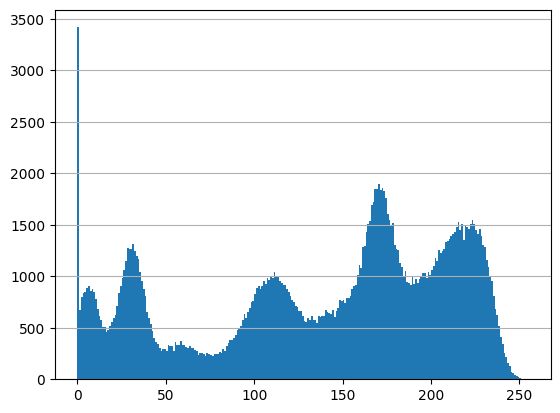

In [33]:
plt.hist(study_array.ravel(),bins = range(0,256))
plt.grid(axis='y')
plt.show()

In [49]:
def convolve(image, kernel):
    # image = image.convert('L')
    kernel_size = kernel.shape[0]
    pad = kernel_size // 2
    rows, cols = image.shape

    padded = np.pad(image, pad, mode='reflect')
    conv_image = np.zeros_like(image, dtype=float)

    for i in range(rows):
        for j in range(cols):
            patch = padded[i:i+kernel_size, j:j+kernel_size]
            conv_image[i, j] = np.sum(patch * kernel)

    return conv_image.astype(np.uint8)
    

In [59]:
average_filter = np.ones((3,3))/9
gaussian_filter = np.array([[1,2,1,],[2,4,2], [1,2,1]])/16

In [ ]:
def sharpenAdjust(img, p):
    # Convert to grayscale
    img = img.convert('L')
    img = np.array(img, dtype=np.float32)

    # Define filters
    average_filter = np.ones((3,3), dtype=np.float32) / 9.0
    gaussian_filter = np.array([[1, 2, 1],
                                [2, 4, 2],
                                [1, 2, 1]], dtype=np.float32) / 16.0
    
    # Blurring
    avg_blurred = convolve(img, average_filter)
    gauss_blurred = convolve(img, gaussian_filter)

    # Unsharp masking
    avg_sharpened = (1 + p) * img - p * avg_blurred
    gauss_sharpened = (1 + p) * img - p * gauss_blurred

    # Clip to valid range
    avg_sharpened = np.clip(avg_sharpened, 0, 255).astype(np.uint8)
    gauss_sharpened = np.clip(gauss_sharpened, 0, 255).astype(np.uint8)

    return avg_sharpened, gauss_sharpened


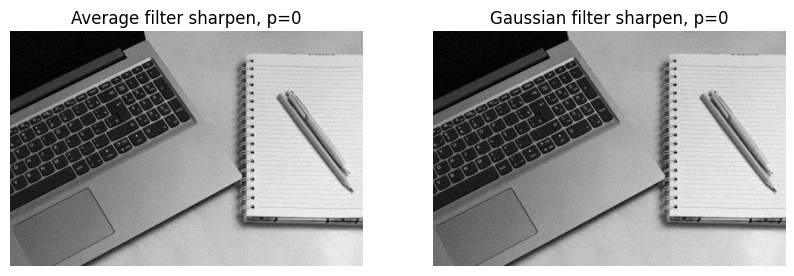

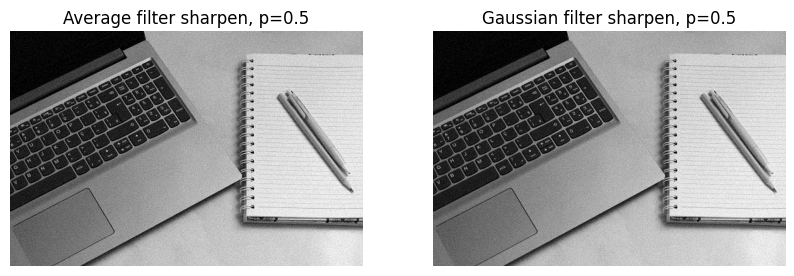

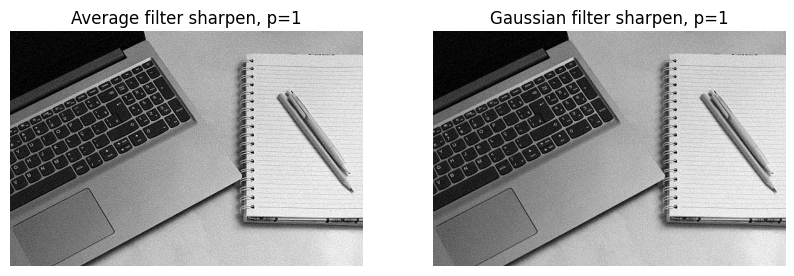

In [ ]:
for p in [0, 0.5, 1]:
    avg_sharp, gauss_sharp = sharpenAdjust(study, p)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(avg_sharp, cmap='gray')
    plt.title(f'Average filter sharpen, p={p}')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(gauss_sharp, cmap='gray')
    plt.title(f'Gaussian filter sharpen, p={p}')
    plt.axis('off')
    plt.show()